In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import numpy as np
from NegativeClassOptimization import config, utils
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from NegativeClassOptimization.preprocessing import *
from NegativeClassOptimization import data_similarity as ds
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from scipy.stats import pearsonr
from pathlib import Path

In [2]:
task_2_folder = {'vs 9':'1v9', 'vs Non-binder':'high_vs_95low', 'vs Weak': 'high_vs_looser', 'vs 1':'1v1'}
tasks = ['vs 9', 'vs Non-binder', 'vs Weak']

In [3]:
ag_order = [
        "1FBI",
        "3VRL",
        "2YPV",
        "5E94",
        "1WEJ",
        "1OB1",
        "1NSN",
        "1H0D",
        "3RAJ",
        "1ADQ",
    ]

In [4]:
cmap = { 'vs 9' : '#FF5733',
         'vs Non-binder':'#00A6ED',
         'vs Weak':'#FFC300',
         'vs 1': '#8B5F4D'}

In [5]:
def get_absolut_train_test_energy(task, ags_list, split):
    reader = lambda path: pd.read_csv(path, compression="zip", sep="\t", header=1)
    
    if task == 'vs 1':
        test_path = glob.glob(str(Path(config.DATA_ML) / f'{task_2_folder[task]}/seed_0/split_{split}/{ags_list[0]}__vs__{ags_list[1]}/*_test_dataset.tsv'))[0]
        train_path = glob.glob(str(Path(config.DATA_ML) / f'{task_2_folder[task]}/seed_0/split_{split}/{ags_list[0]}__vs__{ags_list[1]}/*_train_dataset.tsv'))[0]
    else:
        test_path = glob.glob(str(Path(config.DATA_ML) / f'{task_2_folder[task]}/seed_0/split_{split}/{ags_list[0]}*/*_test_dataset.tsv'))[0]
        train_path = glob.glob(str(Path(config.DATA_ML) / f'{task_2_folder[task]}/seed_0/split_{split}/{ags_list[0]}*/*_train_dataset.tsv'))[0]

    df_test =  pd.read_csv(test_path, sep='\t').drop(['binds_a_pos_ag', 'Slide_onehot', 'X'], axis=1)
    df_train =  pd.read_csv(train_path, sep='\t').drop(['binds_a_pos_ag', 'Slide_onehot', 'X'], axis=1)

    #combine with energy data
    path_pos = glob.glob(str(config.DATA_SLACK_1_RAWBINDINGS_PERCLASS_MURINE/f"{ags_list[0]}*/{ags_list[0]}_[A-Z]_MascotteSlices.txt.zip"))[0]
    pos_eng = reader(path_pos)[['ID_slide_Variant', 'Slide', 'Energy']] 

    if task == 'vs 9':
        paths_neg = set(glob.glob(str(config.DATA_SLACK_1_RAWBINDINGS_PERCLASS_MURINE/f"*/*_MascotteSlices.txt.zip"))) - set([path_pos])
        neg_engs = []
        for path in paths_neg:
            neg_eng = reader(path)[['ID_slide_Variant', 'Slide', 'Energy']] 
            neg_engs.append(neg_eng)
        neg_engs = pd.concat(neg_engs)
        eng_df = pd.concat([pos_eng, neg_engs])
        
    elif task == 'vs 1':
        path_neg = glob.glob(str(config.DATA_SLACK_1_RAWBINDINGS_PERCLASS_MURINE/f"{ags_list[1]}*/{ags_list[1]}_[A-Z]_MascotteSlices.txt.zip"))[0]
        neg_eng = reader(path_neg)[['ID_slide_Variant', 'Slide', 'Energy']] 
        eng_df = pd.concat([pos_eng, neg_eng])

    else:
        path_neg = glob.glob(str(config.DATA_SLACK_1_RAWBINDINGS_PERCLASS_MURINE/f"{ags_list[0]}*/{ags_list[0]}_[A-Z]_500kNonMascotte.txt.zip"))[0]
        path_loose = glob.glob(str(config.DATA_SLACK_1_RAWBINDINGS_PERCLASS_MURINE/f"{ags_list[0]}*/{ags_list[0]}_[A-Z]_LooserExclusiveSlices.txt.zip"))[0]
        neg_eng = reader(path_neg)[['ID_slide_Variant', 'Slide', 'Energy']] 
        wk_eng = reader(path_loose)[['ID_slide_Variant', 'Slide', 'Energy']] 
        eng_df = pd.concat([pos_eng, neg_eng, wk_eng])
    df_test = df_test.merge(eng_df,on='Slide', how='left').drop_duplicates(subset=['Slide', 'Energy'])
    df_train = df_train.merge(eng_df,on='Slide', how='left').drop_duplicates(subset=['Slide', 'Energy'])
    
    return df_train, df_test


In [6]:
EXECUTE = False
#some issue with naming
if EXECUTE:
        task = 'vs 1'
        split = 42 
        for ag_pos in config.ANTIGENS:
                neg_ags =set(config.ANTIGENS) - {ag_pos}
                for ag_neg in neg_ags:
                        df_train, df_test = get_absolut_train_test_energy(task, [ag_pos, ag_neg], split)
                        pairs = ds.find_one_char_diff_pairs(df_train, df_test)
                        leak_df = ds.get_leak_info(df_train,df_test, pairs)
                        leak_df.to_csv(Path(config.DATA_BASE_PATH) / f'data-leak-res/{ag_pos}__{ag_neg}__{task}__{split}.csv')

In [7]:
EXECUTE = False
if EXECUTE:
    for ag in config.ANTIGENS:
        for task in tasks:
            for split in [0,1,2,3,4,42]:
                try:
                    df_train, df_test = get_absolut_train_test_energy(task, [ag], split)
                    pairs = ds.find_one_char_diff_pairs(df_train, df_test)
                    leak_df = ds.get_leak_info(df_train,df_test, pairs)
                    leak_df.to_csv(Path(config.DATA_BASE_PATH) / f'data-leak-res/{ag}__{task}__{split}.csv')
                except IndexError:
                    print('No dataset with given characteristics')

In [8]:
def combine_ag_leaks(task, split=42):
    """I can try to do it over all splits and integrate error  wiskers to the barplots. Otherwise why I calculated all them?"""
    ag_leaks = []
    if task == 'vs 1':
        for ag_pos in config.ANTIGENS:
            neg_ags =set(config.ANTIGENS) - {ag_pos}
            for ag_neg in neg_ags:
                df = pd.read_csv(Path(config.DATA_BASE_PATH) / f'data-leak-res/{ag_pos}__{ag_neg}__{task}__{split}.csv')
                df['pos_ag'] = ag_pos
                df['neg_ag'] = ag_neg
                ag_leaks.append(df)
        ag_leaks_df = pd.concat(ag_leaks)  
    else:
        for ag in config.ANTIGENS:
            df = pd.read_csv(Path(config.DATA_BASE_PATH) / f'data-leak-res/{ag}__{task}__{split}.csv')
            df['Antigen'] = ag
            ag_leaks.append(df)
        ag_leaks_df = pd.concat(ag_leaks)  
    return ag_leaks_df

In [9]:
def label_concordance_count(ag_leaks_df, task,  normalize):
    if normalize:
        if task == 'vs 1':
            grouped_counts = ag_leaks_df.groupby(['pos_ag', 'neg_ag','test_Slide','label_concordance']).size().unstack(level=-1, fill_value=0)
        else:
            grouped_counts = ag_leaks_df.groupby(['Antigen','test_Slide','label_concordance']).size().unstack(level=-1, fill_value=0)
        unique_test_slide_count = 10000 if task != 'vs 9' else 9995
        
        row_sum = grouped_counts.sum(axis=1)
        label_concordance_abundance = grouped_counts.div(row_sum, axis=0)

        if task == 'vs 1':
            #label_concordance_abundance = label_concordance_abundance.sum(axis=0, level=['pos_ag', 'neg_ag'])/unique_test_slide_count 
            label_concordance_abundance = label_concordance_abundance.groupby(level=['pos_ag', 'neg_ag'], axis=0).sum()/unique_test_slide_count 
        else:
            #label_concordance_abundance = label_concordance_abundance.sum(axis=0, level='Antigen')/unique_test_slide_count
            label_concordance_abundance = label_concordance_abundance.groupby(level='Antigen', axis=0).sum()/unique_test_slide_count 
        return label_concordance_abundance
    else:
        if task == 'vs 1':
            conc_count = ag_leaks_df.groupby(['pos_ag', 'neg_ag','label_concordance']).size().reset_index().pivot(columns='label_concordance', index=['pos_ag', 'neg_ag'], values=0)
        else:
            conc_count = ag_leaks_df.groupby(['Antigen','label_concordance']).size().reset_index().pivot(columns='label_concordance', index='Antigen', values=0)
        return conc_count

In [11]:
weak_ags_leaks_df = combine_ag_leaks('vs Weak')
nb_ags_leaks_df = combine_ag_leaks('vs Non-binder')
vs9_ags_leaks_df = combine_ag_leaks('vs 9')
vs1_ags_leaks_df = combine_ag_leaks('vs 1')

In [12]:
weak_conc_count = label_concordance_count(weak_ags_leaks_df, 'vs Weak', True)
nb_conc_count = label_concordance_count(nb_ags_leaks_df, 'vs Non-binder', True)
vs9_conc_count = label_concordance_count(vs9_ags_leaks_df, 'vs 9', True)

In [13]:
v1_conc_count = label_concordance_count(vs1_ags_leaks_df, 'vs 1', True)
v1_conc_count = v1_conc_count.reset_index()

In [14]:
v1_conc_count['conc_count'] = v1_conc_count['++'] + v1_conc_count['--']
v1_conc_count['discor_count'] = v1_conc_count['+-'] + v1_conc_count['-+']

In [15]:
v1_conc_count['ag_pairs'] = v1_conc_count.apply(lambda row: '_'.join(sorted([row['pos_ag'], row['neg_ag']])), axis=1)
v1_conc_count_reduced = v1_conc_count.drop_duplicates(subset='ag_pairs')[['pos_ag', 'neg_ag', 'conc_count', 'discor_count']]

In [16]:
v1_leak_conc_heatmap = v1_conc_count.pivot(index='pos_ag', columns='neg_ag', values='conc_count').loc[ag_order][ag_order]
v1_leak_discor_heatmap = v1_conc_count.pivot(index='pos_ag', columns='neg_ag', values='discor_count').loc[ag_order][ag_order]

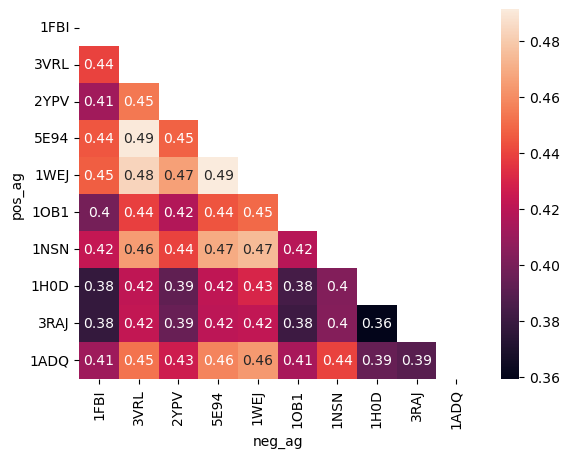

In [17]:
plt.rcParams['svg.fonttype'] = 'none'
mask = np.triu(v1_leak_conc_heatmap)
sns.heatmap(v1_leak_conc_heatmap, annot=True, mask=mask)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.savefig('./figures/vs1_conc_leak.svg')

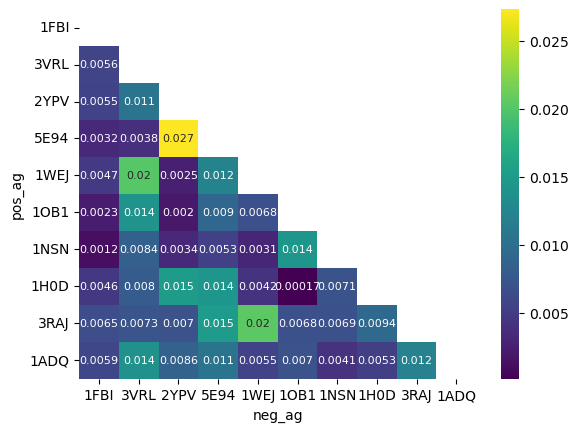

In [18]:
plt.rcParams['svg.fonttype'] = 'none'
mask = np.triu(v1_leak_discor_heatmap)
sns.heatmap(v1_leak_discor_heatmap, annot=True, annot_kws={"fontsize":8}, mask=mask, cmap='viridis') #these are totsl numbers
plt.yticks(rotation=0)
plt.savefig('./figures/vs1_discor_leak.svg')

In [19]:
col_order = ['++', '--', '+-', '-+']

In [20]:
def put_numbers_to_barplt(count_df):
    for i, ag in enumerate(ag_order):
        base = 0
        for color in col_order:
            y = count_df.loc[ag][color].round(2)
            plt.text(x=i-0.2, y=y/2+base, s=y, size="small")
            base += y

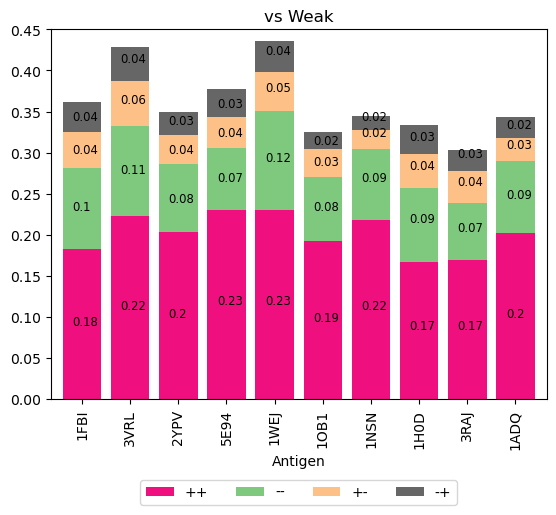

In [21]:
plt.rcParams['svg.fonttype'] = 'none'

weak_conc_count[col_order].loc[ag_order].plot(kind='bar', stacked=True, color=["#F00F7F", "#7FC97F", "#FDC086","#666666"], ylim=(0,0.45), width=0.8)
plt.title('vs Weak')
#hue_order=['++', '--', '+-', '-+'], order=ag_order, palette={"++": "#F00F7F", "--": "#7FC97F","+-": "#FDC086","-+":"#666666"}
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20), ncol=5)
put_numbers_to_barplt(weak_conc_count)
plt.savefig('./figures/leak_90%_weak_recalc.svg')

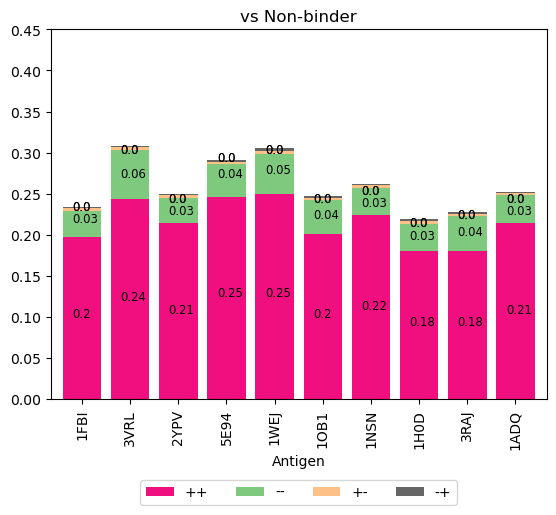

In [22]:
plt.rcParams['svg.fonttype'] = 'none'
#sns.set_style("white")
#sns.set_style('ticks')

nb_conc_count[col_order].loc[ag_order].plot(kind='bar', stacked=True, color=["#F00F7F", "#7FC97F", "#FDC086","#666666"], ylim=(0,0.45), width=0.8)
plt.title('vs Non-binder')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20), ncol=5)
put_numbers_to_barplt(nb_conc_count)
plt.savefig('./figures/leak_90%_nb_recalc.svg')

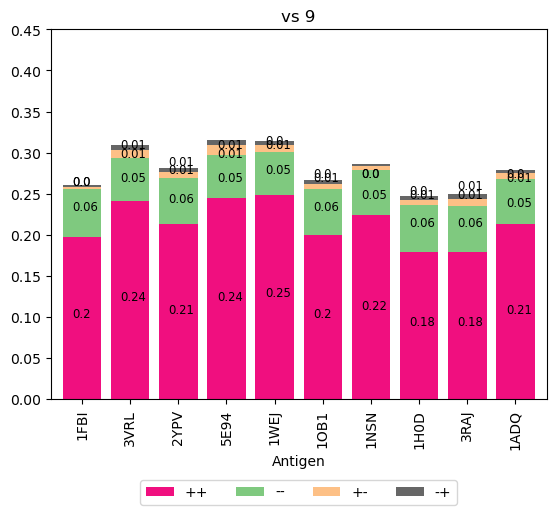

In [23]:
plt.rcParams['svg.fonttype'] = 'none'
#sns.set_style("white")
#sns.set_style('ticks')

vs9_conc_count[col_order].loc[ag_order].plot(kind='bar', stacked=True, color=["#F00F7F", "#7FC97F", "#FDC086","#666666"], ylim=(0,0.45), width=0.8)
plt.title('vs 9')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20), ncol=5)
put_numbers_to_barplt(vs9_conc_count)
plt.savefig('./figures/leak_90%_vs9_recalc.svg')

In [24]:
weak_ags_leaks_df['Energy_diff_abs'] = weak_ags_leaks_df['Energy_diff'].abs()
nb_ags_leaks_df['Energy_diff_abs'] = nb_ags_leaks_df['Energy_diff'].abs()
vs9_ags_leaks_df['Energy_diff_abs'] = vs9_ags_leaks_df['Energy_diff'].abs()

In [25]:
vs9_ags_leaks_df[vs9_ags_leaks_df["label_concordance"] == '--']

,Unnamed: 0,train_Slide,test_Slide,label_concordance,Energy_diff,Antigen,Energy_diff_abs
0,0,REGGLLLFDYW,AEGGLLLFDYW,--,0.79,3VRL,0.79
2,2,REGLLPWYFDV,AEGLLPWYFDV,--,1.37,3VRL,1.37
4,4,ATLLRSWFAYW,AFLLRSWFAYW,--,4.25,3VRL,4.25
5,5,AFLLRAWFAYW,AFLLRSWFAYW,--,-14.74,3VRL,14.74
20,20,AIIYYGNYAWF,AIFYYGNYAWF,--,1.46,3VRL,1.46
...,...,...,...,...,...,...,...
5287,5287,YRWLLHWYFDV,YRWLLSWYFDV,--,-0.44,1OB1,0.44
5288,5288,YRYYLYYFDYW,YRYALYYFDYW,--,0.00,1OB1,0.00
5296,5296,LVYYGNYLFAY,YVYYGNYLFAY,--,-3.21,1OB1,3.21
5297,5297,MVYYGNYLFAY,YVYYGNYLFAY,--,-0.72,1OB1,0.72


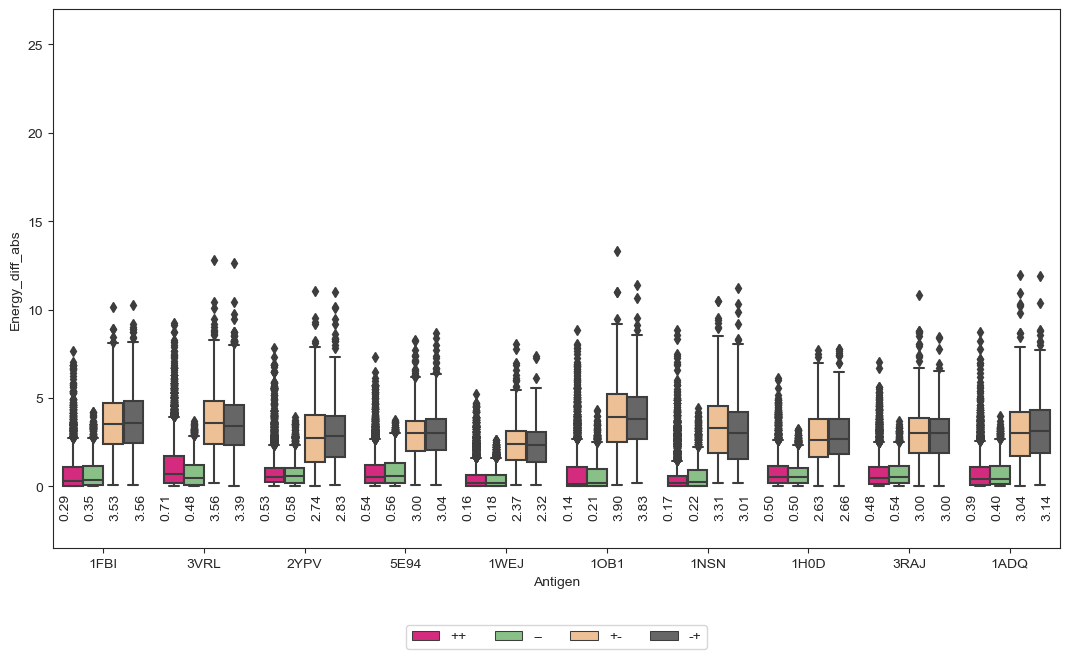

In [26]:
plt.rcParams['svg.fonttype'] = 'none'
sns.set_style("white")
sns.set_style('ticks')

plt.figure(figsize=(13, 7))
plt.ylim([-3.5,27])
hue_order=['++', '--', '+-', '-+']

sns.boxplot(weak_ags_leaks_df, x='Antigen', y='Energy_diff_abs', hue='label_concordance', showfliers=True,\
            hue_order=hue_order, order=ag_order, palette={"++": "#F00F7F", "--": "#7FC97F","+-": "#FDC086","-+":"#666666"})

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.13), ncol=5)
ds.plot_median_for_energy_diff(weak_ags_leaks_df, hue_order, 'Antigen', ag_order) 
plt.savefig('./figures/leak_energy_weak_recalc_font.svg', transparent=True)

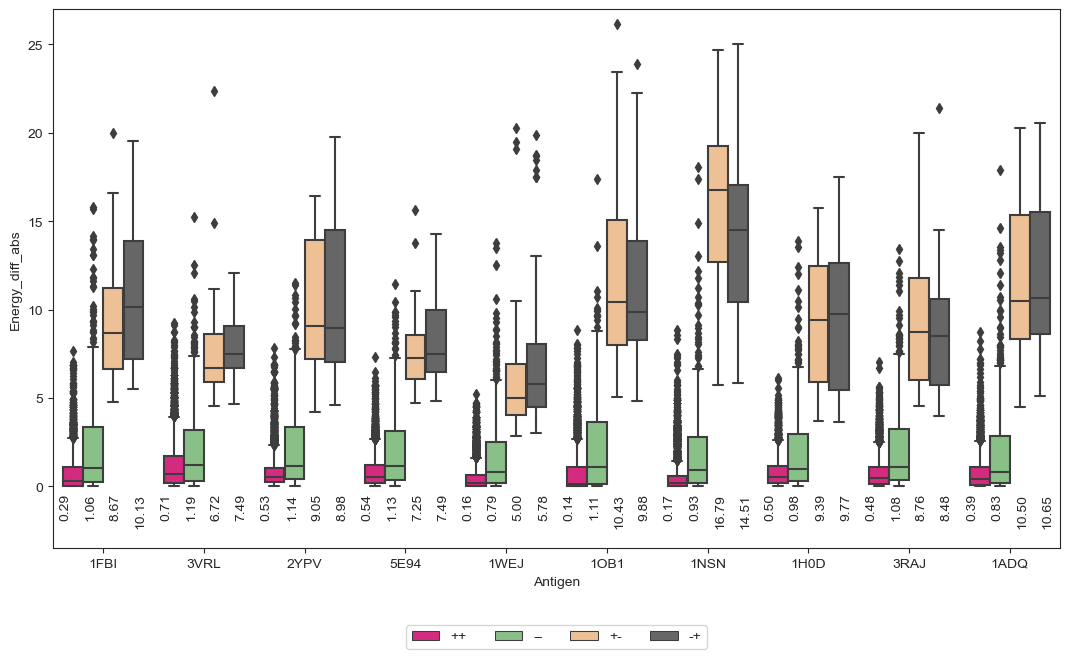

In [27]:
plt.rcParams['svg.fonttype'] = 'none'
sns.set_style("white")
sns.set_style('ticks')

plt.figure(figsize=(13, 7))
plt.ylim([-3.5,27])
hue_order=['++', '--', '+-', '-+']

sns.boxplot(nb_ags_leaks_df, x='Antigen', y='Energy_diff_abs', hue='label_concordance', showfliers=True,\
            hue_order=hue_order, order=ag_order, palette={"++": "#F00F7F", "--": "#7FC97F","+-": "#FDC086","-+":"#666666"})

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.13), ncol=5)

ds.plot_median_for_energy_diff(nb_ags_leaks_df, hue_order, 'Antigen', ag_order) 


plt.savefig('./figures/leak_energy_nb_recalc_bigger.svg')

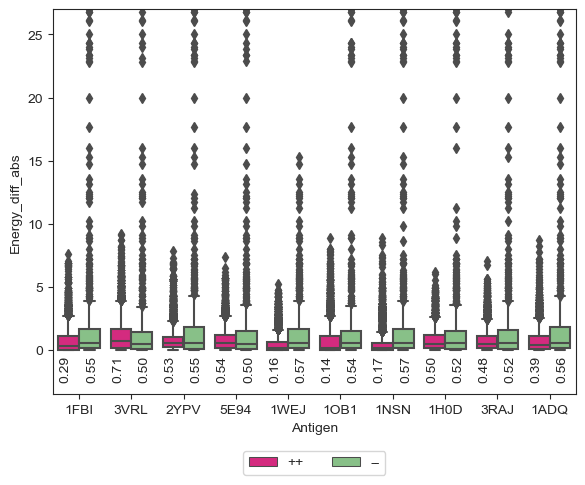

In [28]:
#!!! this is different from what is in the paper more outliers. This image is the crrect one will have to change. Good it is a supplementary image.
plt.rcParams['svg.fonttype'] = 'none'
sns.set_style("white")
sns.set_style('ticks')

plt.figure(figsize=(6.75, 5))
plt.ylim([-3.5,27])
hue_order=['++', '--']

sns.boxplot(vs9_ags_leaks_df, x='Antigen', y='Energy_diff_abs', showfliers=True,\
            hue='label_concordance', hue_order=hue_order, order=ag_order, palette={"++": "#F00F7F", "--": "#7FC97F"})

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.13), ncol=5)
#plot_meadian_for_energy_diff(vs9_ags_leaks_df, hue_order)
ds.plot_median_for_energy_diff(vs9_ags_leaks_df, hue_order, 'Antigen', ag_order)


plt.savefig('./figures/leak_energy_vs9_recalc.svg')

In [29]:
##How leak correlates with performance?
perf_df = pd.read_csv(config.DATA_BASE_PATH/'openset_performance.tsv', sep='\t')
perf_df[['train_task', 'train_ag', 'train_neg', 'seed_id', 'split_id']] = perf_df.task_1.str.split('__', expand=True)
perf_df[['test_task', 'test_ag', 'test_neg', 'test_seed_id', 'test_split_id']] = perf_df.task_2.str.split('__', expand=True)
perf_df.drop(['task_1', 'task_2'], inplace=True, axis=1)
task_rename = {'ONE_VS_NINE': 'vs 9', 'HIGH_VS_95LOW': 'vs Non-binder', 'HIGH_VS_LOOSER': 'vs Weak', 'ONE_VS_ONE': 'vs 1'}
perf_df['train_task'] = perf_df['train_task'].apply(lambda x: task_rename[x])
perf_df['test_task'] = perf_df['test_task'].apply(lambda x: task_rename[x])

In [30]:
perf_closed = perf_df[perf_df['train_task'] == perf_df['test_task']]

In [32]:
weak_ags_leaks_df['Energy_diff_abs'] = weak_ags_leaks_df['Energy_diff'].abs()
nb_ags_leaks_df['Energy_diff_abs'] = nb_ags_leaks_df['Energy_diff'].abs()
vs9_ags_leaks_df['Energy_diff_abs'] = vs9_ags_leaks_df['Energy_diff'].abs()

In [33]:
def leak_perf_corr(task, split, labels_to_keep, energy_cut=False):
    df_leak = combine_ag_leaks(task) 
    if energy_cut:
        df_leak = df_leak[df_leak['Energy_diff'].abs() <= energy_cut]
    conc_count = label_concordance_count(df_leak, task, True)
    conc_count = conc_count[labels_to_keep].sum(axis=1).reset_index().rename(columns={0:'leak_ratio'})
    #getting performances
    task_selection = perf_closed['train_task'] == task
    seed_selection = perf_closed['test_seed_id'] == '0'
    split_selectio = perf_closed['test_split_id'] == str(split)
    perf_task = perf_closed[task_selection & seed_selection & split_selectio][['train_ag', 'acc']]
    perf_leak_df = perf_task.merge(conc_count, left_on='train_ag', right_on='Antigen')
    perf_leak_df = perf_leak_df.groupby('Antigen').mean('acc').reset_index() 
    return perf_leak_df



In [34]:
def leak_open_perf_corr(train_task, test_task, split, labels_to_keep,  energy_cut=False):
    df_leak = combine_ag_leaks(train_task) 
    if energy_cut:
        df_leak = df_leak[df_leak['Energy_diff'].abs() <= energy_cut]
    conc_count = label_concordance_count(df_leak, train_task, True)
    conc_count = conc_count[labels_to_keep].sum(axis=1).reset_index().rename(columns={0:'leak_ratio'})
    #getting performances
    task_selection = (perf_df['train_task'] == train_task) & (perf_df['test_task'] == test_task)
    seed_selection = perf_df['test_seed_id'] == '0'
    split_selectio = perf_df['test_split_id'] == str(split)
    perf_task = perf_df[task_selection & seed_selection & split_selectio][['train_ag', 'acc']]
    perf_leak_df = perf_task.merge(conc_count, left_on='train_ag', right_on='Antigen')
    perf_leak_df = perf_leak_df.groupby('Antigen').mean('acc').reset_index() #added for testing

    return perf_leak_df



In [35]:
split =42
task = 'vs Non-binder'
perf_leak_nb = leak_perf_corr(task, split, ['++', '--'])

task = 'vs Weak'
perf_leak_wk = leak_perf_corr(task, split, ['++', '--'])

task = 'vs 9'
perf_leak_vs9 = leak_perf_corr(task, split, ['++', '--'])

In [36]:
def corr_to_plot(xs, ys):
    r, pval = pearsonr(xs, ys)
    x_plot = xs.mean()
    y_plot = ys.mean()
    return r, x_plot, y_plot, pval

In [37]:
seed = 0

In [38]:
df_1vs1_perf = pd.read_csv(config.DATA_BASE_PATH/'1vs1_perf.tsv', sep='\t', index_col=0)
df_1vs1_perf = df_1vs1_perf[(df_1vs1_perf['seed_id'] == seed) & (df_1vs1_perf['split_id'] == split)]
df_1vs1_perf = df_1vs1_perf.rename(columns={'train_ag': 'pos_ag','train_neg': 'neg_ag'})

In [39]:
perf_leak_vs1 = v1_conc_count.merge(df_1vs1_perf, on = ['pos_ag', 'neg_ag'])
perf_leak_vs1_wo_dupl = perf_leak_vs1.drop_duplicates('ag_pairs')

In [40]:
perf_leak_vs1_wo_dupl.shape

(45, 21)

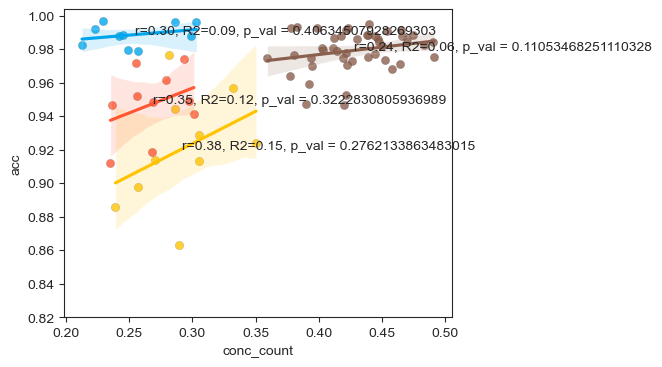

In [41]:
plt.rcParams['svg.fonttype'] = 'none'
sns.set_style("white")
sns.set_style('ticks')

fig, ax = plt.subplots(figsize=(5,4))
sns.regplot(data=perf_leak_nb, x='leak_ratio', y='acc',ax=ax, color='#00A6ED', scatter_kws={'edgecolor': 'black', 'linewidth': 0.1})
r, x_plot, y_plot, pval = corr_to_plot(perf_leak_nb['leak_ratio'], perf_leak_nb['acc'])
ax.text(x_plot, y_plot, f"r={r:.2f}, R2={r**2:.2f}, p_val = {pval}" , fontsize=10)

sns.regplot(data=perf_leak_wk, x='leak_ratio', y='acc',ax=ax, color='#FFC300', scatter_kws={'edgecolor': 'black', 'linewidth': 0.1})
r, x_plot, y_plot, pval = corr_to_plot(perf_leak_wk['leak_ratio'], perf_leak_wk['acc'])
ax.text(x_plot, y_plot, f"r={r:.2f}, R2={r**2:.2f}, p_val = {pval}" , fontsize=10)

sns.regplot(data=perf_leak_vs9, x='leak_ratio', y='acc',ax=ax, color='#FF5733', scatter_kws={'edgecolor': 'black', 'linewidth': 0.1})
r, x_plot, y_plot, pval = corr_to_plot(perf_leak_vs9['leak_ratio'], perf_leak_vs9['acc'])
ax.text(x_plot, y_plot, f"r={r:.2f}, R2={r**2:.2f}, p_val = {pval}" , fontsize=10)

sns.regplot(data=perf_leak_vs1_wo_dupl, x='conc_count', y='acc', color='#8B5F4D', scatter_kws={'edgecolor': 'black', 'linewidth': 0.1}, ax=ax)
r, x_plot, y_plot, pval = corr_to_plot(perf_leak_vs1_wo_dupl['conc_count'], perf_leak_vs1_wo_dupl['acc'])
ax.text(x_plot, y_plot, f"r={r:.2f}, R2={r**2:.2f}, p_val = {pval}" , fontsize=10)
plt.yticks(np.arange(0.82, 1,0.02))

fig.savefig('./figures/leak_corr_recalc.svg')

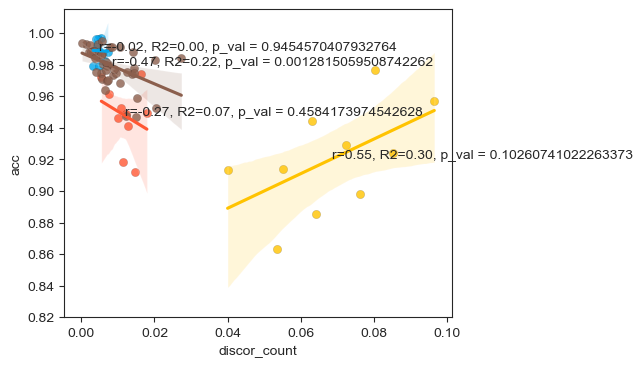

In [42]:
split =42
task = 'vs Non-binder'
perf_leak_nb_dis = leak_perf_corr(task, split, ['+-', '-+'])

task = 'vs Weak'
perf_leak_wk_dis = leak_perf_corr(task, split,['+-', '-+'])

task = 'vs 9'
perf_leak_vs9_dis = leak_perf_corr(task, split,['+-', '-+'])


plt.rcParams['svg.fonttype'] = 'none'
sns.set_style("white")
sns.set_style('ticks')

fig, ax = plt.subplots(figsize=(5,4))
sns.regplot(data=perf_leak_nb_dis, x='leak_ratio', y='acc',ax=ax, color='#00A6ED', scatter_kws={'edgecolor': 'black', 'linewidth': 0.1})
r, x_plot, y_plot, pval = corr_to_plot(perf_leak_nb_dis['leak_ratio'], perf_leak_nb_dis['acc'])
ax.text(x_plot, y_plot, f"r={r:.2f}, R2={r**2:.2f}, p_val = {pval}" , fontsize=10)

sns.regplot(data=perf_leak_wk_dis, x='leak_ratio', y='acc',ax=ax, color='#FFC300', scatter_kws={'edgecolor': 'black', 'linewidth': 0.1})
r, x_plot, y_plot, pval = corr_to_plot(perf_leak_wk_dis['leak_ratio'], perf_leak_wk_dis['acc'])
ax.text(x_plot, y_plot, f"r={r:.2f}, R2={r**2:.2f}, p_val = {pval}" , fontsize=10)

sns.regplot(data=perf_leak_vs9_dis, x='leak_ratio', y='acc',ax=ax, color='#FF5733', scatter_kws={'edgecolor': 'black', 'linewidth': 0.1})
r, x_plot, y_plot, pval = corr_to_plot(perf_leak_vs9_dis['leak_ratio'], perf_leak_vs9_dis['acc'])
ax.text(x_plot, y_plot, f"r={r:.2f}, R2={r**2:.2f}, p_val = {pval}" , fontsize=10)

sns.regplot(data=perf_leak_vs1_wo_dupl, x='discor_count', y='acc', color='#8B5F4D', scatter_kws={'edgecolor': 'black', 'linewidth': 0.1}, ax=ax)
r, x_plot, y_plot, pval = corr_to_plot(perf_leak_vs1_wo_dupl['discor_count'], perf_leak_vs1_wo_dupl['acc'])
ax.text(x_plot, y_plot, f"r={r:.2f}, R2={r**2:.2f}, p_val = {pval}" , fontsize=10)
plt.yticks(np.arange(0.82, 1,0.02))
fig.savefig('./figures/leak_corr_difflabes.svg')

In [43]:
split =42
task = 'vs Non-binder'
test_task = 'vs Weak'
ood_perf_leak_nb_weak = leak_open_perf_corr(task, test_task, split, ['++', '--'])
test_task = 'vs 9'
ood_perf_leak_nb_vs9 = leak_open_perf_corr(task, test_task, split, ['++', '--'])

task = 'vs Weak'
test_task = 'vs Non-binder'
ood_leak_wk_nb = leak_open_perf_corr(task, test_task, split, ['++', '--'])
test_task = 'vs 9'
ood_leak_wk_vs9 = leak_open_perf_corr(task, test_task, split, ['++', '--'])

task = 'vs 9'
test_task = 'vs Non-binder'
ood_leak_wk_vs9_nb = leak_open_perf_corr(task, test_task, split, ['++', '--'])
test_task = 'vs Weak'
ood_leak_wk_vs9_weak = leak_open_perf_corr(task, test_task, split, ['++', '--'])


In [44]:
split =42
task = 'vs Non-binder'
test_task = 'vs Weak'
ood_perf_leak_nb_weak = leak_open_perf_corr(task, test_task, split, ['++', '--'])
test_task = 'vs 9'
ood_perf_leak_nb_vs9 = leak_open_perf_corr(task, test_task, split, ['++', '--'])

task = 'vs Weak'
test_task = 'vs Non-binder'
ood_leak_wk_nb = leak_open_perf_corr(task, test_task, split, ['++', '--'])
test_task = 'vs 9'
ood_leak_wk_vs9 = leak_open_perf_corr(task, test_task, split, ['++', '--'])

task = 'vs 9'
test_task = 'vs Non-binder'
ood_leak_wk_vs9_nb = leak_open_perf_corr(task, test_task, split, ['++', '--'])
test_task = 'vs Weak'
ood_leak_wk_vs9_weak = leak_open_perf_corr(task, test_task, split, ['++', '--'])


In [45]:
def plot_ood_leak_correlation(perf_leak_df, train_task, test_task, ax):

    sns.regplot(data=perf_leak_df, x='leak_ratio', y='acc', color=cmap[test_task], scatter_kws={'edgecolor': 'black', 'linewidth': 0.1}, ax=ax)
    ax.set_title(f'Train task: {train_task}')
    r, x_plot, y_plot, pval = corr_to_plot(perf_leak_df['leak_ratio'], perf_leak_df['acc'])
    ax.text(x_plot, y_plot, f"r={r:.2f}, R2={r**2:.2f},\n p_val = {pval}" , fontsize=10)

In [46]:
ood_perf_leak_nb_weak = leak_open_perf_corr(task, test_task, split, ['++', '--'])
test_task = 'vs 9'
ood_perf_leak_nb_vs9 = leak_open_perf_corr(task, test_task, split, ['++', '--'])

task = 'vs Weak'
test_task = 'vs Non-binder'
ood_leak_wk_nb = leak_open_perf_corr(task, test_task, split, ['++', '--'])
test_task = 'vs 9'
ood_leak_wk_vs9 = leak_open_perf_corr(task, test_task, split, ['++', '--'])

task = 'vs 9'
test_task = 'vs Non-binder'
ood_leak_vs9_nb = leak_open_perf_corr(task, test_task, split, ['++', '--'])
test_task = 'vs Weak'
ood_leak_vs9_weak = leak_open_perf_corr(task, test_task, split, ['++', '--'])

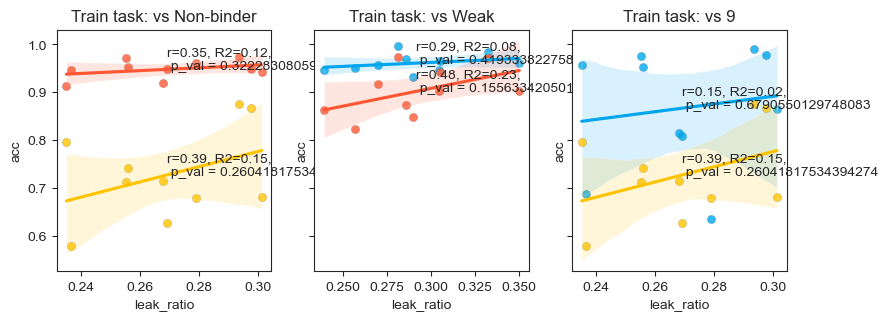

In [47]:
fig, ax = plt.subplots(1, 3, figsize=(3*3.14,3.14), sharey=True)

plot_ood_leak_correlation(ood_perf_leak_nb_weak, 'vs Non-binder', 'vs Weak', ax[0])
plot_ood_leak_correlation(ood_perf_leak_nb_vs9, 'vs Non-binder', 'vs 9', ax[0])

plot_ood_leak_correlation(ood_leak_wk_nb, 'vs Weak', 'vs Non-binder', ax[1])
plot_ood_leak_correlation(ood_leak_wk_vs9, 'vs Weak', 'vs 9', ax[1])

plot_ood_leak_correlation(ood_leak_vs9_nb, 'vs 9', 'vs Non-binder', ax[2])
plot_ood_leak_correlation(ood_leak_vs9_weak, 'vs 9', 'vs Weak', ax[2])


### Model SN10 error rate on test seq tha thave one mutation away sequence in train dataset

Some ab in train data is one aa away from test data, they might be similar in labels or different or both at the same time. If ab contributes only into ine type of label (dis)concordance then they will be called consistent, else ambiguous

In [48]:
task_2TASK = {'vs 9': 'ONE_VS_NINE', 'vs Non-binder': 'HIGH_VS_95LOW', 'vs Weak': 'HIGH_VS_LOOSER'}
tasks_dict = {'ONE_VS_NINE': '1v9', 'HIGH_VS_95LOW': 'high_vs_95low', 'HIGH_VS_LOOSER': 'high_vs_looser'}
task_template = {'ONE_VS_NINE': '{ag}__vs__9', 'HIGH_VS_95LOW': '{ag}_high__vs__{ag}_95low', 'HIGH_VS_LOOSER': '{ag}_high__vs__{ag}_looser'}

In [49]:
def model_mistakes_on_leak(task, seed, split, leaks_df_all_ag, consistent_leak=True):
    TASK = task_2TASK[task]
    error_rate_ag =dict()
    for ag in config.ANTIGENS:
        model_path = config.DATA_ML / f"{tasks_dict[TASK]}/seed_{seed}/split_{split}/{task_template[TASK].format(ag=ag)}/swa_model/data/model.pth"
        model = torch.load(model_path, map_location=torch.device('cpu'))
        leaks_df = leaks_df_all_ag[leaks_df_all_ag['Antigen'] == ag]
        leaks_df_intersections = leaks_df[['test_Slide', 'label_concordance']].groupby('test_Slide').nunique().reset_index()
        if consistent_leak:
            leaks_df = leaks_df_intersections[leaks_df_intersections['label_concordance']==1].copy()
        else:
            leaks_df = leaks_df_intersections[leaks_df_intersections['label_concordance']!=1].copy()

        leaks_df['X'] = leaks_df.test_Slide.apply(onehot_encode)
        X = torch.tensor(np.array(leaks_df['X'].tolist()), dtype=torch.float32).to('cpu')
        y_pred = model(X, return_logits = False)
        y_pred = y_pred.cpu().detach().numpy().reshape(-1).round()
        leaks_df['y_pred'] = y_pred
        test_df_path = glob.glob(str(config.DATA_ML / f"{tasks_dict[TASK]}/seed_{seed}/split_{split}/{task_template[TASK].format(ag=ag)}/*_test_dataset.tsv"))[0]
        test_df = pd.read_csv(test_df_path, sep='\t')
        leaks_df = leaks_df.merge(test_df[['Slide', 'y']], how='left', left_on = 'test_Slide', right_on = 'Slide' )
        error_rate = (leaks_df['y_pred'] !=  leaks_df['y']).sum()/len(leaks_df)
        error_rate_ag[ag] = error_rate
    return error_rate_ag


In [50]:
leaks_df_ex = weak_ags_leaks_df[weak_ags_leaks_df['Antigen'] == '1ADQ']
leaks_df_ex.head()

,Unnamed: 0,train_Slide,test_Slide,label_concordance,Energy_diff,Antigen,Energy_diff_abs
0,0,AALITTVGWYF,AAFITTVGWYF,++,-0.12,1ADQ,0.12
1,1,CAGWLLLYFDY,AAGWLLLYFDY,++,-2.04,1ADQ,2.04
2,2,RAGWLLLYFDY,AAGWLLLYFDY,++,0.64,1ADQ,0.64
3,3,ARGWLLLYFDY,AAGWLLLYFDY,++,1.30,1ADQ,1.30
4,4,AINYAWYFDVW,ACNYAWYFDVW,+-,-2.86,1ADQ,2.86


In [51]:
weak_certain = model_mistakes_on_leak('vs Weak', 0, 42, weak_ags_leaks_df)
weak_certain_amb = model_mistakes_on_leak('vs Weak', 0, 42, weak_ags_leaks_df, False)

In [52]:
def combine_error_rates(task, seed, split, leaks_df_all_ag):
    certain = model_mistakes_on_leak(task,  seed, split, leaks_df_all_ag)
    ambiguous = model_mistakes_on_leak(task,  seed, split, leaks_df_all_ag, False)
    certain = pd.DataFrame.from_dict(certain, orient='index', columns=['error_rate_cons']).rename_axis('Antigen').reset_index()
    ambiguous = pd.DataFrame.from_dict(ambiguous, orient='index', columns=['error_rate_amb']).rename_axis('Antigen').reset_index()
    error_rate_df =certain.merge(ambiguous, on='Antigen')
    return error_rate_df

In [53]:
weak_leak_error_rates = combine_error_rates('vs Weak', 0, 42, weak_ags_leaks_df)

In [54]:
nb_leak_error_rates = combine_error_rates('vs Non-binder', 0, 42, nb_ags_leaks_df)

In [55]:
vs9_leak_error_rates = combine_error_rates('vs 9', 0, 42, vs9_ags_leaks_df)

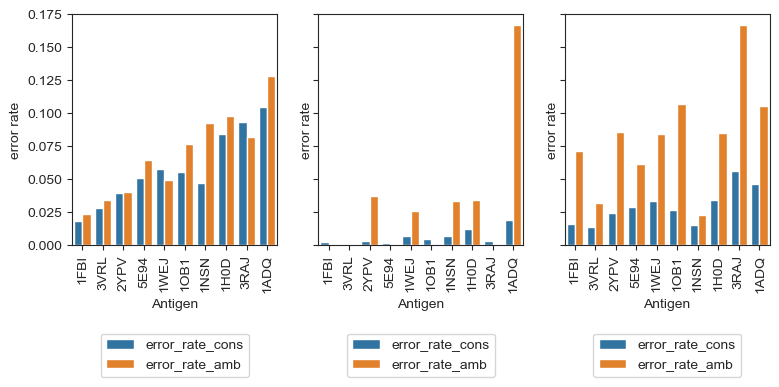

In [56]:
fig, ax = plt.subplots(nrows=1, ncols=3, sharey = True, figsize=(3*3,3))

weak_leak_error_rates_melt = weak_leak_error_rates.melt(value_vars=["error_rate_cons", "error_rate_amb"], value_name="error rate", id_vars=['Antigen'])
sns.barplot(weak_leak_error_rates_melt, x='Antigen', y='error rate', hue='variable', order=ag_order,ax=ax[0])
nb_leak_error_rates_melt = nb_leak_error_rates.melt(value_vars=["error_rate_cons", "error_rate_amb"], value_name="error rate", id_vars=['Antigen'])
sns.barplot(nb_leak_error_rates_melt, x='Antigen', y='error rate', hue='variable', order=ag_order,ax=ax[1])
vs9_leak_error_rates_melt = vs9_leak_error_rates.melt(value_vars=["error_rate_cons", "error_rate_amb"], value_name="error rate", id_vars=['Antigen'])
sns.barplot(vs9_leak_error_rates_melt, x='Antigen', y='error rate', hue='variable', order=ag_order, ax=ax[2])

for i in range(3):
    ax[i].set_xticklabels(ag_order,rotation=90)
    ax[i].legend(loc='lower center', bbox_to_anchor=(0.5, -0.6))

#will be good to add "non-leak" seq error rate